In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import cv2
import pickle

In [137]:
def init_tumor2(size, radius):
    """
     initializes the field phi with a circle
     :param size: size of matrix
     :param radius: tumor initial radius (created in center)
     :return param phi: order parameter matrix
    """
    cx,cy = int(size/2),int(size/2)
    x, y = np.indices((size, size))
    phi = (np.abs(np.hypot(x-cx, y-cy)) < radius).astype(float)
    return phi

In [227]:
def init_tumor_ellipse(size,a,b,radius):
    cx,cy = int(size/2),int(size/2)
    x, y = np.indices((size, size))
    phi = (np.abs(np.hypot((x-cx)/a, (y-cy)/b)) < radius).astype(float)
    return phi

In [25]:
def init_s2(size):
    s = 2.55 + 0.4 * np.random.rand(size,size)
    return s

In [294]:
def integrate_5(phi, sigma, S, dt, h, **kwargs):
    """
      integrate the order parameter phi and the chemical field sigma one tstep
      with 5x5 stencil (five point stencil - https://en.wikipedia.org/wiki/Five-point_stencil)
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    stencil_5 = (1.0 / (12.0 * h * h)) * np.array(
        [[0, 0, -1, 0, 0],
         [0, 0, 16, 0, 0],
         [-1, 16, -60, 16, -1],
         [0, 0, 16, 0, 0],
         [0, 0, -1, 0, 0]])

    phiold = np.copy(phi)
    phinew = phi + dt * (kwargs['lambda_'] * convolve(phi, stencil_5, mode='nearest') +
                      (64.0/kwargs['tau']) * phi * (1.0 - phi) * (phi - 0.5) +
                      kwargs['chi'] * sigma * phi - kwargs['A'] * phi)

    sigmanew = sigma + dt * (kwargs['epsilon']*kwargs['lambda_'] * convolve(sigma, stencil_5, mode='nearest') +
                              S - kwargs['delta'] * phiold - kwargs['gamma'] * sigma)    

    return phinew, sigmanew

In [295]:
def integrate_5_nophi(phi, sigma, S, dt, h, **kwargs):
    """
      integrate the order parameter phi and the chemical field sigma one tstep
      with 5x5 stencil (five point stencil - https://en.wikipedia.org/wiki/Five-point_stencil)
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    stencil_5 = (1.0 / (12.0 * h * h)) * np.array(
        [[0, 0, -1, 0, 0],
         [0, 0, 16, 0, 0],
         [-1, 16, -60, 16, -1],
         [0, 0, 16, 0, 0],
         [0, 0, -1, 0, 0]])

    phiold = np.copy(phi)
    phinew = phi + dt * (kwargs['lambda_'] * convolve(phi, stencil_5, mode='nearest') +
                      (64.0/kwargs['tau']) * phi * (1.0 - phi) * (phi - 0.5) +
                      kwargs['chi'] * sigma - kwargs['A'] * phi)

    sigmanew = sigma + dt * (kwargs['epsilon']*kwargs['lambda_'] * convolve(sigma, stencil_5, mode='nearest') +
                              S - kwargs['delta'] * phiold - kwargs['gamma'] * sigma)    

    return phinew, sigmanew

In [296]:
def fintegrate(phi, sigma, S, dt, h, **kwargs):
    """
      try to go even faster
      -> don't create copy here
      -> try to reduce multiplications
      -> cv2 for convolution?
      -> replace convolve(phi, stencil_5, mode='nearest')
      integrate the order parameter phi and the chemical field sigma one tstep
      with 5x5 stencil (five point stencil - https://en.wikipedia.org/wiki/Five-point_stencil)
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    stencil_5 = (1.0 / (12.0 * h * h)) * np.array(
        [[0, 0, -1, 0, 0],
         [0, 0, 16, 0, 0],
         [-1, 16, -60, 16, -1],
         [0, 0, 16, 0, 0],
         [0, 0, -1, 0, 0]])
    
    phinew = phi + dt * (kwargs['lambda_'] * cv2.filter2D(phi,-1,stencil_5,borderType=cv2.BORDER_REPLICATE) +
                      (64.0/kwargs['tau']) * phi * (1.0 - phi) * (phi - 0.5) +
                      kwargs['chi'] * sigma * phi - kwargs['A'] * phi)

    sigmanew = sigma + dt * (kwargs['epsilon']*kwargs['lambda_'] * cv2.filter2D(sigma,-1,stencil_5,borderType=cv2.BORDER_REPLICATE) +
                              S - kwargs['delta'] * phi - kwargs['gamma'] * sigma)    

    return phinew, sigmanew

In [297]:
def fintegrate_nophi(phi, sigma, S, dt, h, **kwargs):
    """
      try to go even faster
      -> don't create copy here
      -> try to reduce multiplications
      -> cv2 for convolution?
      integrate the order parameter phi and the chemical field sigma one tstep
      with 5x5 stencil (five point stencil - https://en.wikipedia.org/wiki/Five-point_stencil)
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    stencil_5 = (1.0 / (12.0 * h * h)) * np.array(
        [[0, 0, -1, 0, 0],
         [0, 0, 16, 0, 0],
         [-1, 16, -60, 16, -1],
         [0, 0, 16, 0, 0],
         [0, 0, -1, 0, 0]])

    phinew = phi + dt * (kwargs['lambda_'] * cv2.filter2D(phi,-1,stencil_5,borderType=cv2.BORDER_REPLICATE) +
                      (64.0/kwargs['tau']) * phi * (1.0 - phi) * (phi - 0.5) +
                      kwargs['chi'] * sigma - kwargs['A'] * phi)

    # take care, tau was previously not inversed here!
    # 64 also introduced
    # epsilon now in relation to lambda
    sigmanew = sigma + dt * (kwargs['epsilon']*kwargs['lambda_'] * cv2.filter2D(sigma,-1,stencil_5,borderType=cv2.BORDER_REPLICATE) +
                              S - kwargs['delta'] * phi - kwargs['gamma'] * sigma)    

    return phinew, sigmanew

In [299]:
# compare timings of cv2 vs scipy implementation
phiold = np.copy(phi)
sigmaold = np.copy(sigma)
%timeit fintegrate(phiold, sigmaold, S, **param)
phiold = np.copy(phi)
sigmaold = np.copy(sigma)
%timeit integrate_5(phiold, sigmaold, S, **param)

679 µs ± 8.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.16 ms ± 3.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [71]:
res_run1={'phi':phinew_5,'sigma':sigmanew_5}
res_run1.update(param)
with open('run1.pickle', 'wb') as handle:
    pickle.dump(res_run1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [211]:
# init params + fields
size = 200
L = np.array([size, size])  # system length
phi = init_tumor2(size, 50)  # initializing the tumor field
sigma = init_s2(size)
S = np.copy(sigma)
param = {'dt':0.00025, 'h':5., 'lambda_':432., 'epsilon':40., 
         'A':0.8, 'gamma':2.74, 'tau':3.65, 'chi':1.09, 'delta':2.75}
tstep = 90/param['dt'] # in days150000

0.0


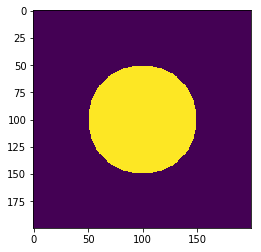

1.0


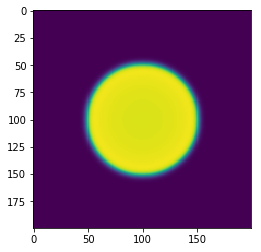

2.0


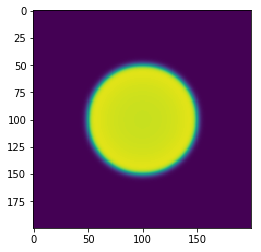

3.0


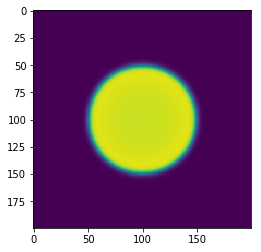

4.0


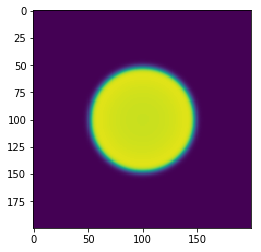

5.0


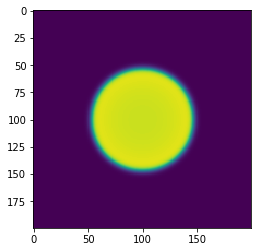

KeyboardInterrupt: 

In [212]:
phiold = np.copy(phi)
sigmaold = np.copy(sigma)

for iteration in np.arange(tstep):
    phinew, sigmanew = integrate_5(phiold, sigmaold, S, **param) # so far S does not change
    phiold = phinew
    sigmaold = sigmanew
    
    if iteration%int(1/param['dt']) == 0:
        print(iteration*param['dt'])
        plt.imshow(phiold,vmin=0,vmax=1)
        #plt.imshow(sigmaold,vmin=0,vmax=3)
        plt.show()

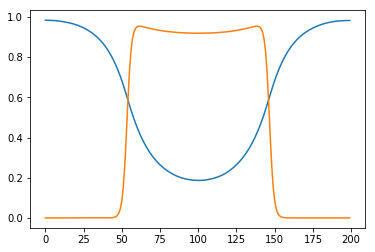

In [215]:
plt.plot(sigmaold[100,:])
plt.plot(phiold[100,:])

In [287]:
# init params + fields
size = 200
L = np.array([size, size])  # system length
#phi = init_tumor2(size, 50)  # initializing the tumor field
phi = init_tumor_ellipse(size,1,1.3,50)
sigma = np.ones((size,size),dtype=float)
S = init_s2(size)
param = {'dt':0.00025, 'h':5., 'lambda_':432., 'epsilon':40., 
         'A':1.2, 'gamma':2.74, 'tau':3.65, 'chi':1.09, 'delta':2.75}
days = 150
tstep = days/param['dt'] # in days150000

0.0


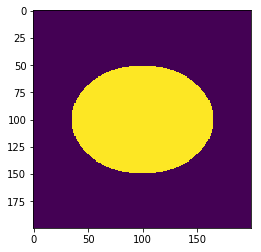

1.0


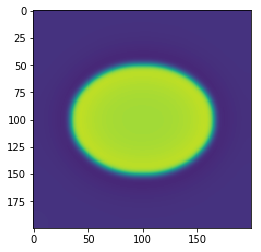

2.0


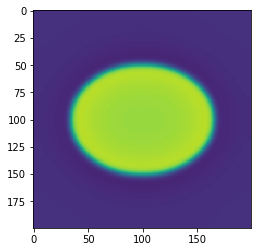

3.0


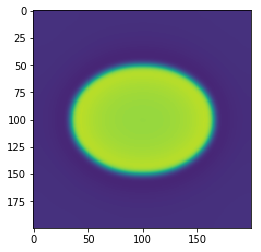

4.0


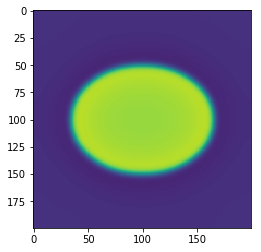

5.0


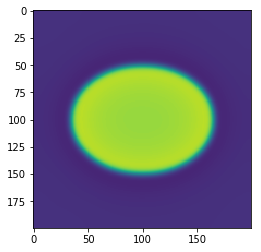

6.0


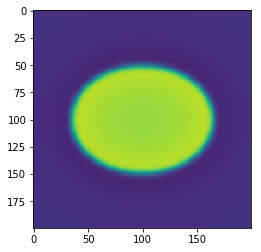

7.0


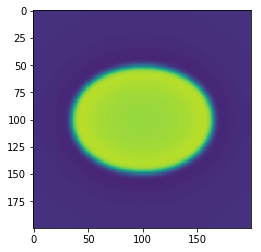

8.0


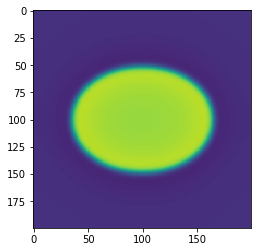

9.0


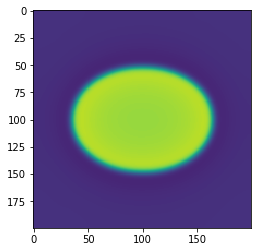

10.0


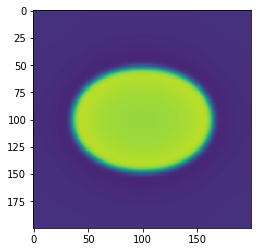

11.0


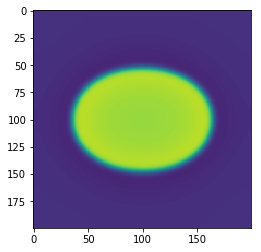

12.0


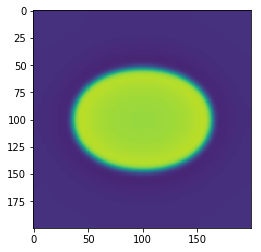

13.0


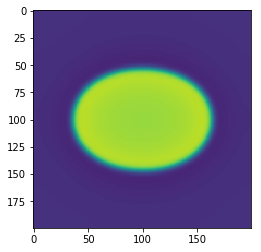

14.0


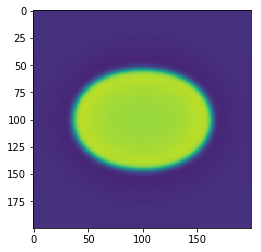

15.0


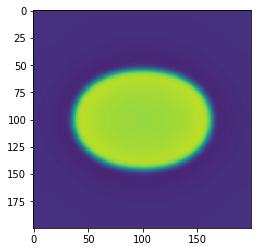

16.0


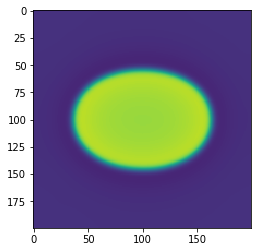

17.0


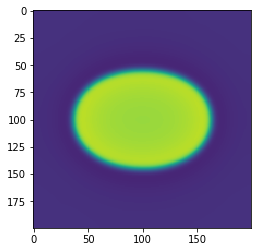

18.0


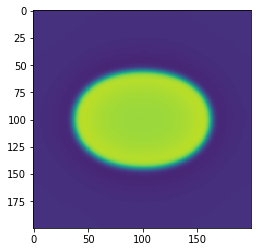

19.0


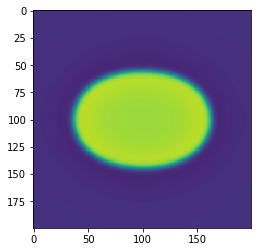

20.0


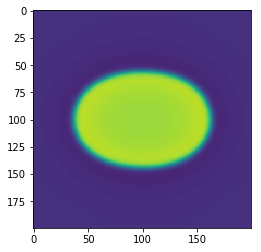

21.0


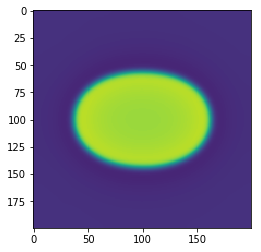

22.0


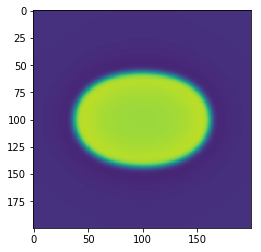

23.0


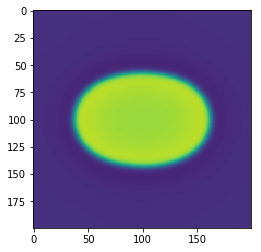

24.0


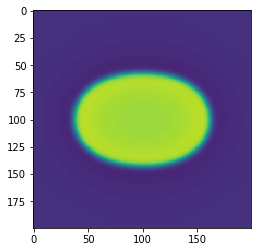

25.0


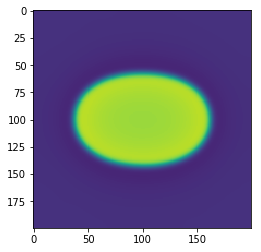

26.0


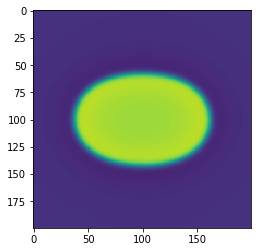

27.0


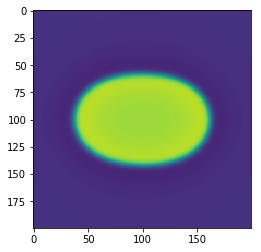

28.0


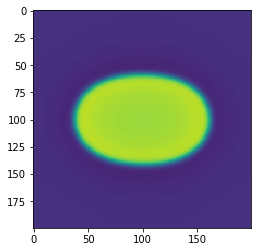

29.0


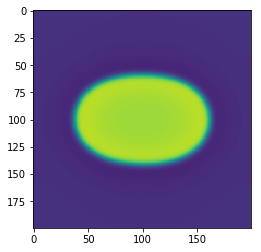

30.0


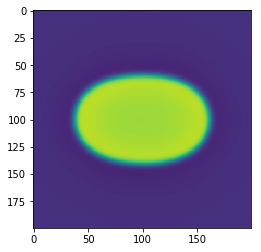

31.0


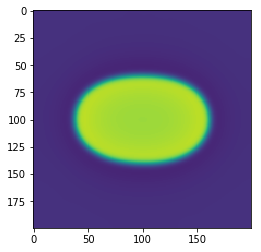

32.0


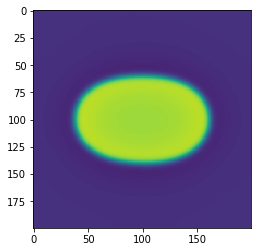

33.0


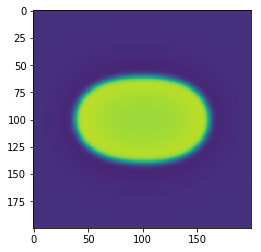

34.0


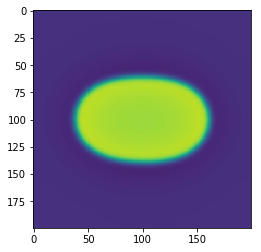

35.0


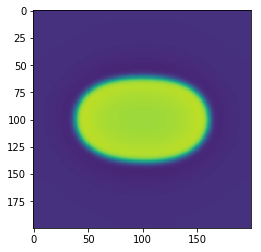

36.0


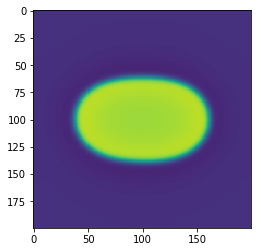

37.0


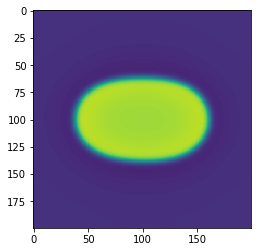

38.0


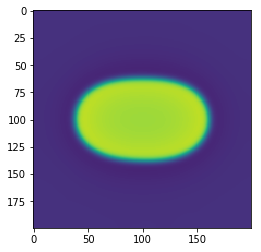

39.0


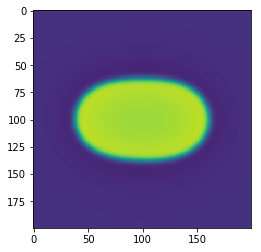

40.0


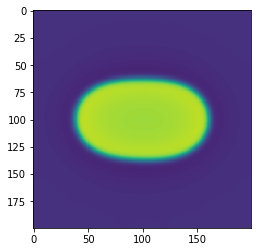

41.0


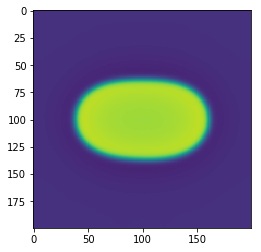

42.0


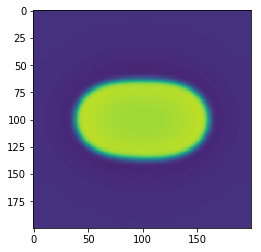

43.0


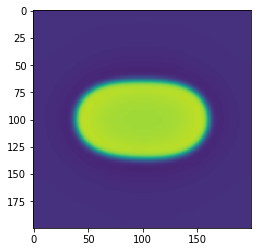

44.0


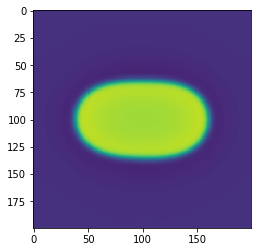

45.0


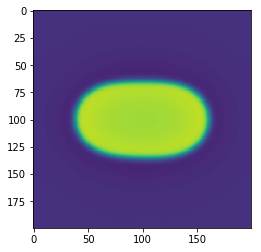

46.0


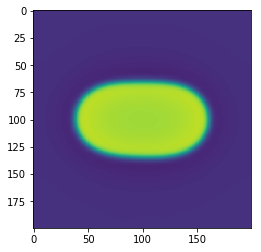

47.0


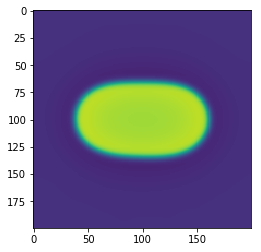

48.0


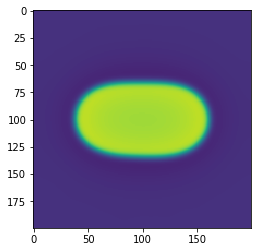

49.0


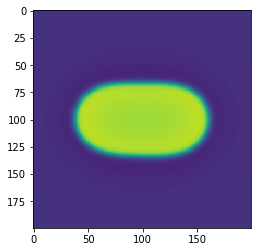

50.0


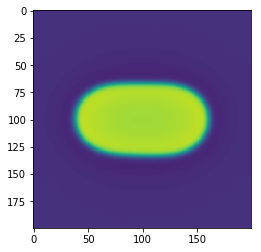

51.0


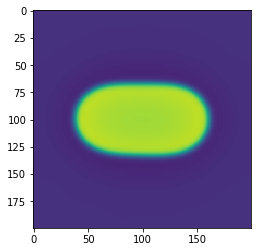

52.0


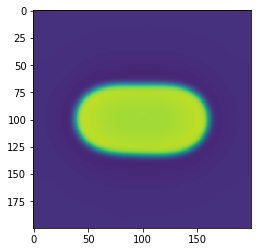

53.0


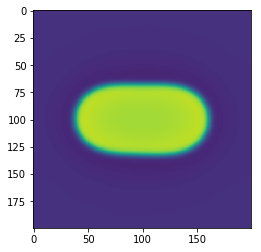

54.0


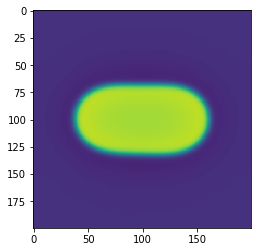

55.0


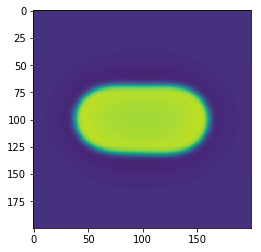

56.0


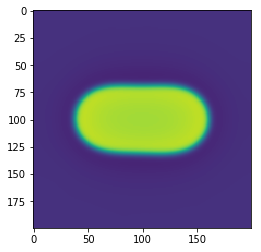

57.0


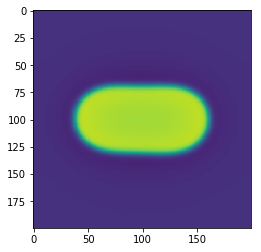

58.0


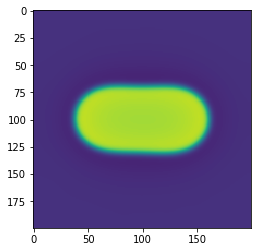

59.0


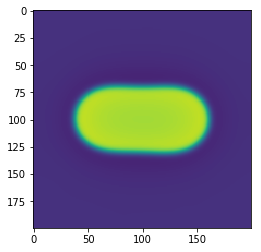

60.0


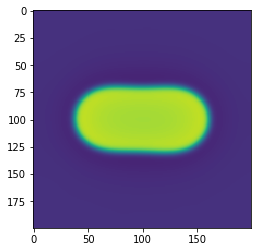

61.0


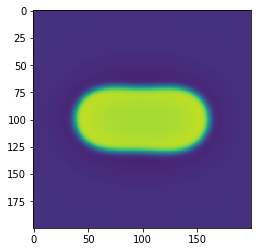

62.0


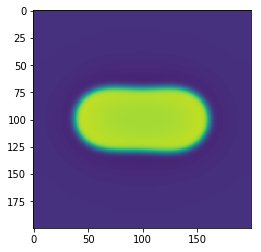

63.0


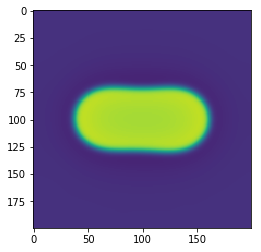

64.0


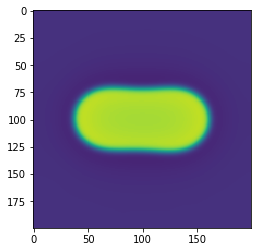

65.0


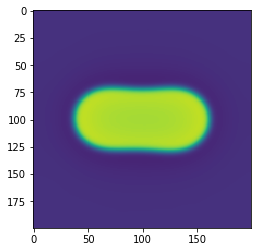

66.0


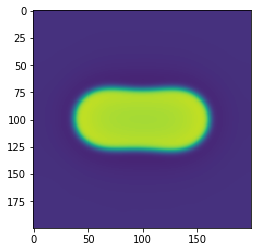

67.0


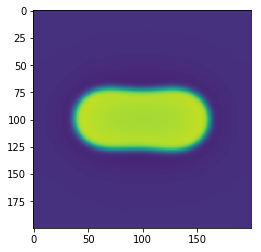

68.0


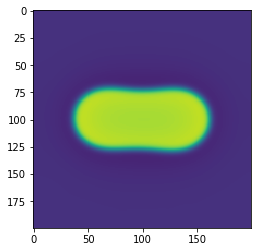

69.0


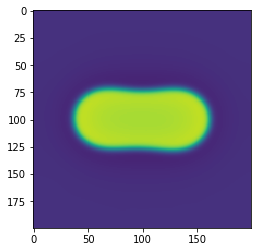

70.0


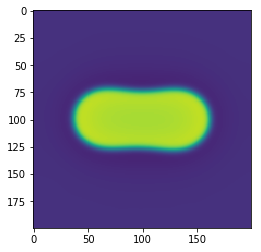

71.0


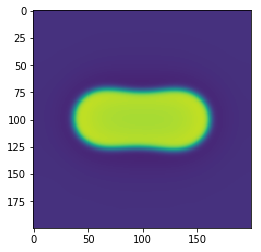

72.0


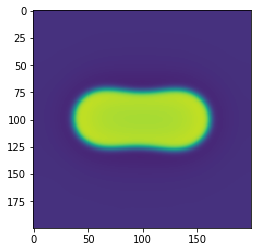

73.0


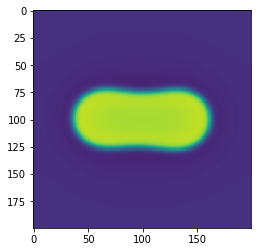

74.0


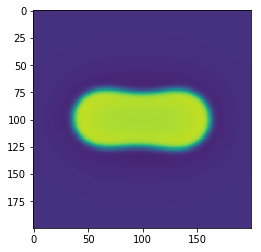

75.0


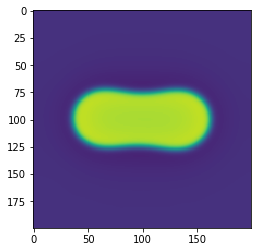

76.0


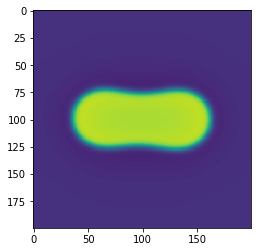

77.0


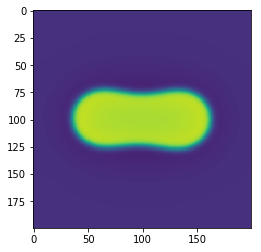

78.0


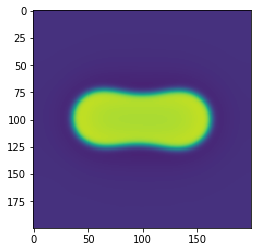

79.0


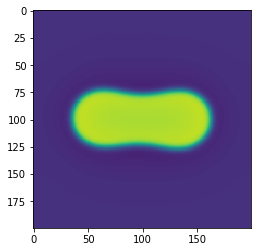

80.0


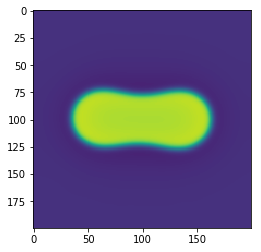

81.0


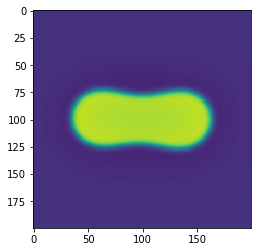

82.0


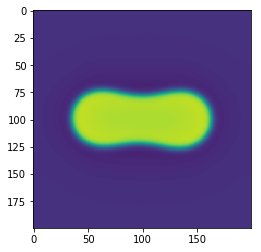

83.0


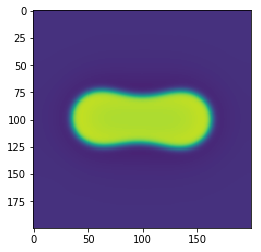

84.0


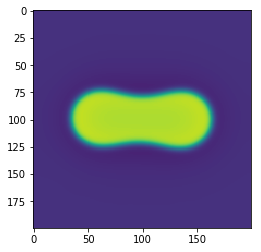

85.0


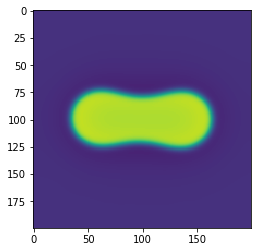

86.0


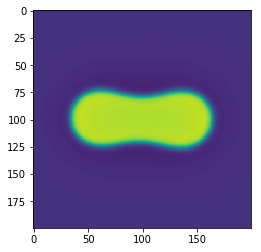

87.0


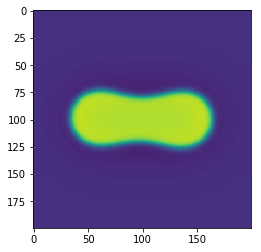

88.0


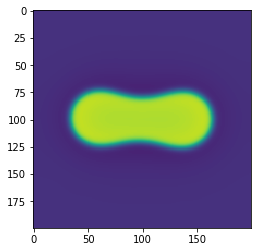

89.0


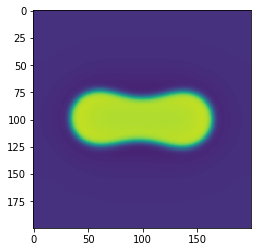

90.0


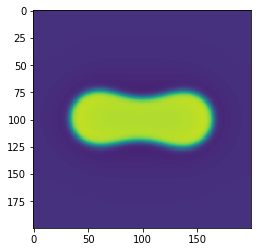

91.0


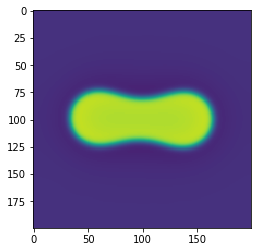

92.0


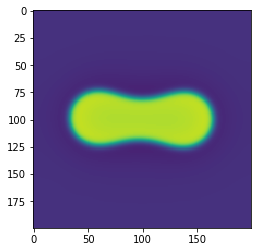

93.0


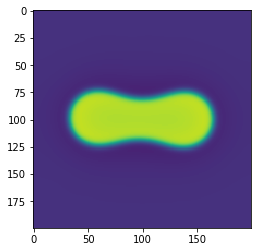

94.0


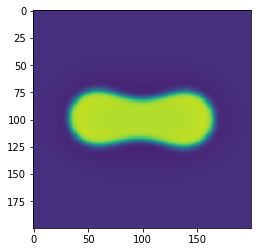

95.0


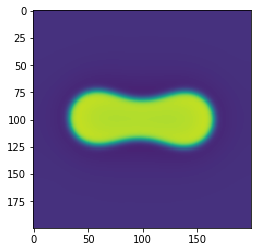

96.0


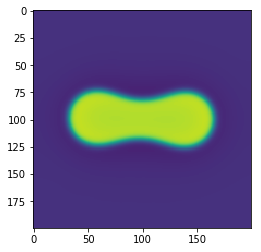

97.0


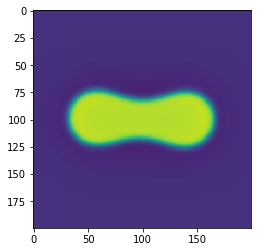

98.0


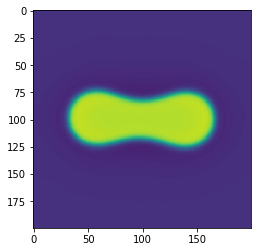

99.0


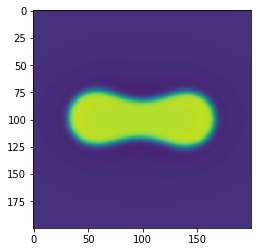

100.0


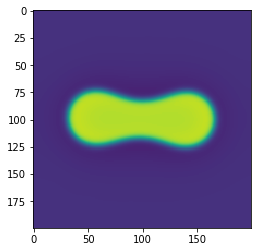

101.0


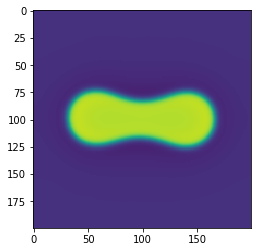

102.0


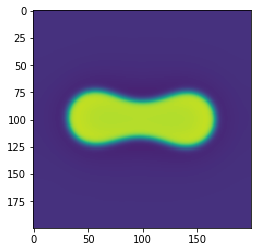

103.0


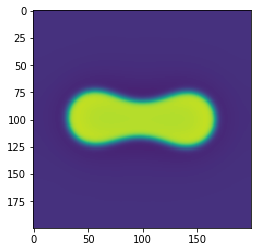

104.0


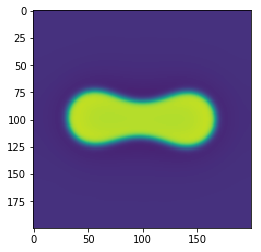

105.0


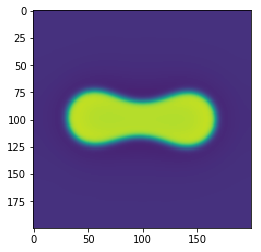

106.0


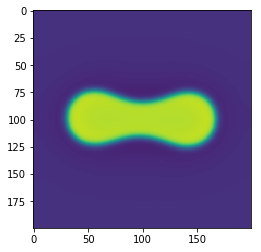

107.0


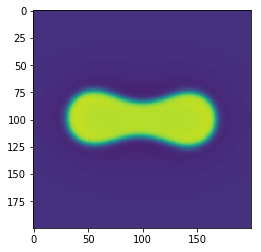

108.0


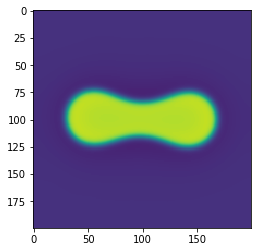

109.0


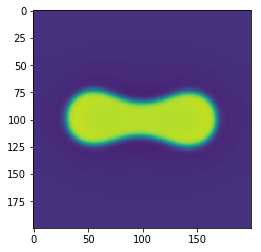

110.0


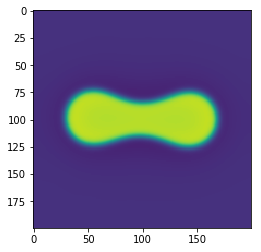

111.0


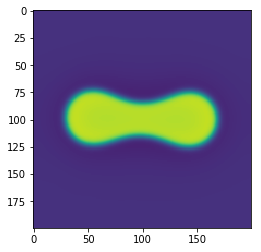

112.0


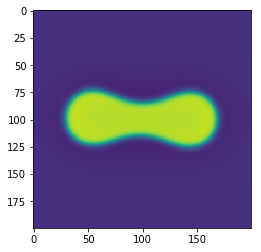

113.0


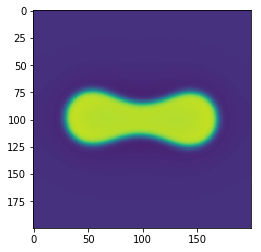

114.0


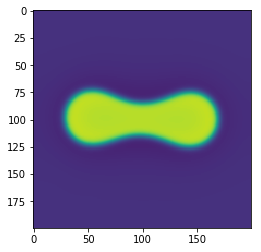

115.0


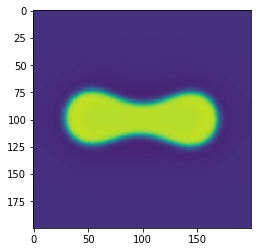

116.0


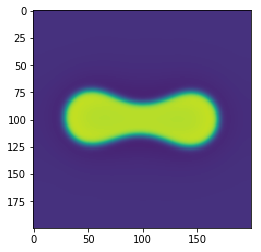

117.0


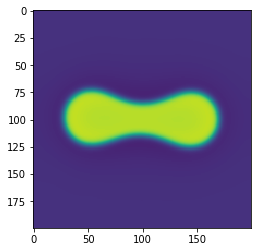

118.0


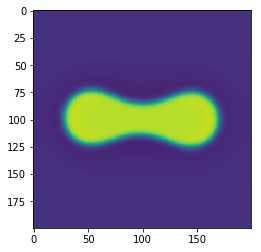

119.0


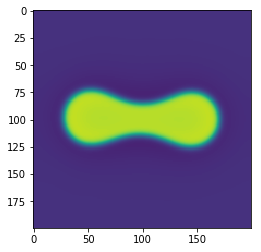

120.0


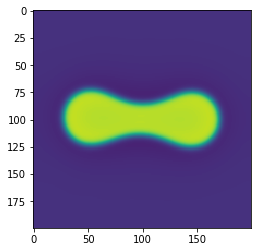

121.0


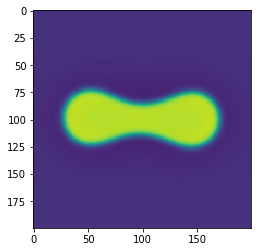

122.0


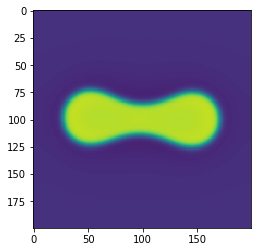

123.0


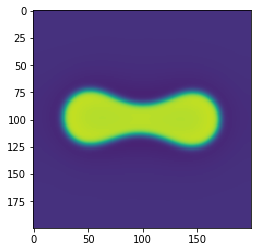

124.0


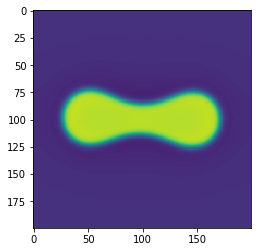

125.0


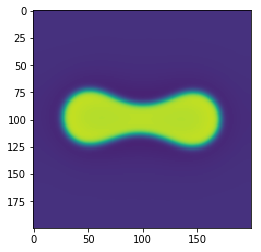

126.0


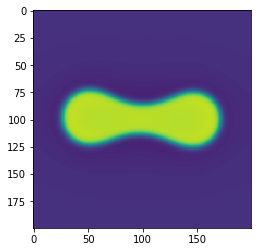

127.0


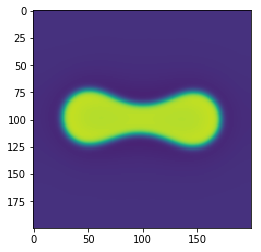

128.0


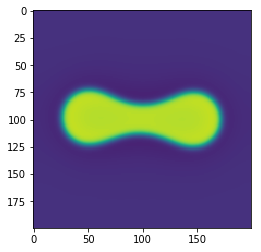

129.0


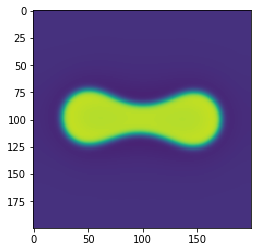

130.0


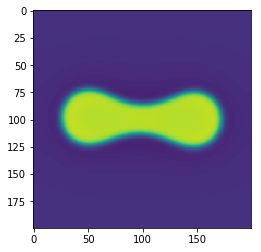

131.0


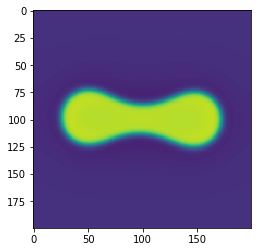

132.0


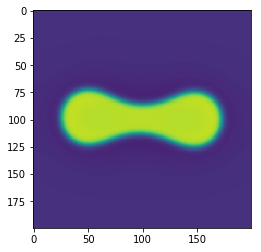

133.0


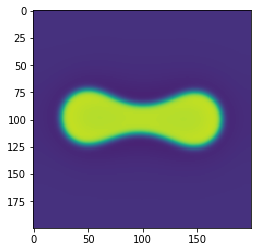

134.0


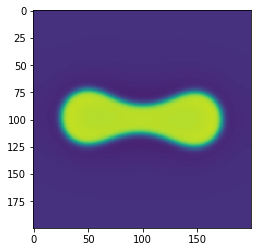

135.0


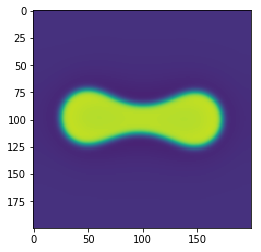

136.0


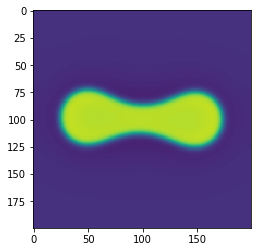

137.0


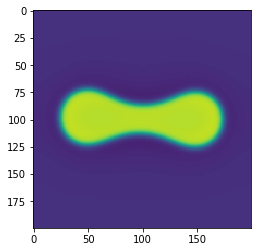

138.0


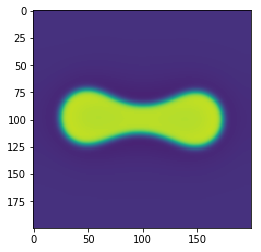

139.0


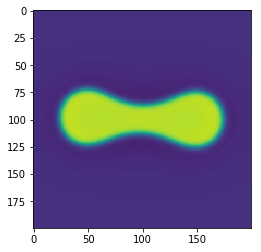

140.0


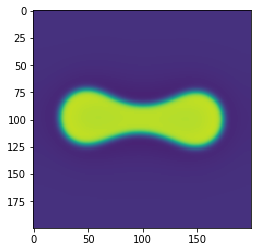

141.0


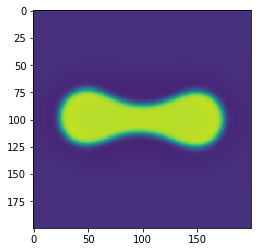

142.0


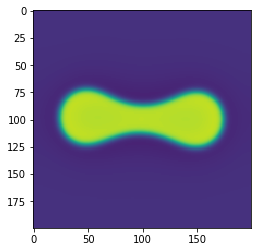

143.0


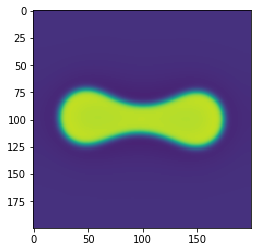

144.0


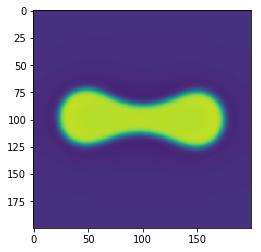

145.0


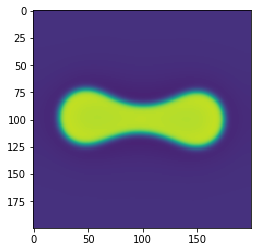

146.0


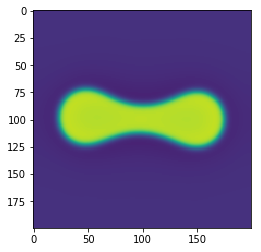

147.0


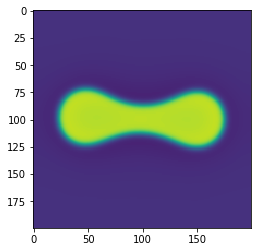

148.0


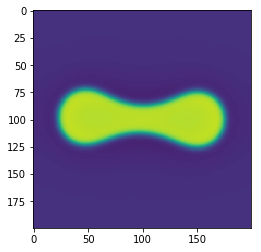

149.0


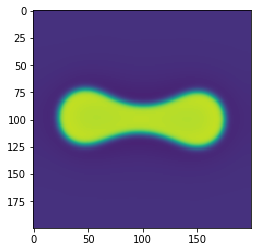

In [288]:
# check sign of 1/tau!!!
phiold = np.copy(phi)
sigmaold = np.copy(sigma)
phiarr = np.zeros((days,size,size))

for iteration in np.arange(tstep):
    phinew, sigmanew = fintegrate_nophi(phiold, sigmaold, S, **param) # so far S does not change
    phiold = phinew
    sigmaold = sigmanew
    
    if iteration%int(1/param['dt']) == 0:
        phiarr[int(iteration*param['dt'])]=phinew
        print(iteration*param['dt'])
        plt.imshow(phiold,vmin=0,vmax=1)
        #plt.imshow(sigmaold,vmin=0,vmax=3)
        plt.show()

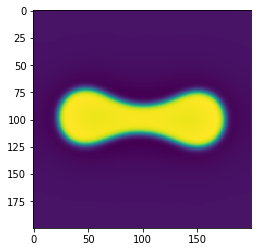

In [293]:
plt.imshow(phiarr[149])